## Personalized Medicine: Redefining Cancer Treatment
<Br>    </Br>
Based on the type of gene mutation, a unique cancer treatment is tailored and provided to the patient. One of the significant steps in identifying the personalized medicince for cancer treatment is <u>finding the type (or class) of gene mutation</u>.
<Br>    </Br>
#### <B>Objective:</B>  
Classify the gene mutation into one of 9 classes based on clinical evidence from literature
<Br>    </Br>

#### <B>Machine learning problem:</B>  
Multi-class classification problem with categorical and text features as input.
<Br></Br> 

#### <B>Model metric</B>: 
Primary: Logloss <Br>
Secondary: Confusion matrix
<Br></Br> 

#### <B>Data source:</B> 
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
Input files: 
    - File 1 contains information on gene, gene variation and the class of gene mutation (target feature)
    - File 2 contains clinical evidence (information from medical literature). This is in free text form


<u>**Table of contents** </u>

<a href='#data_cleaning'>1. Data Cleaning</a> <br>
<a href='#eda'>2. Exploratory Data Analysis</a><br>
<a href='#univariate_gene'>2.1 Univariate Analysis: Gene</a><br>
<a href='#model'>3. Modelling of data</a><br>
<a href='#ohe-count'>
3.1 Onehot encoded gene and variation features; and count vectorized text feature</a><br>
<a href='#te-count'>
3.2 Target encoded Gene and variation feature with count vectorized text features</a><br>
<a href='#te-tfidf'>
3.3 Target encoded Gene and Variation features with tf-idf vectorized text feature</a><br>
<a href='#te-w2vec'>
3.4 Target encoded Gene and Variation features with TF_IDF weighted word2vector</a><br>
<a href='#final_model'>4. Finalized model and analysis of predicted probabilities</a><br>
<a href='#next_steps'>5. Next Steps</a><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kstest
import re
import collections
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, confusion_matrix,accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from nltk.corpus import stopwords
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('wordnet')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import en_core_sci_sm, en_core_web_sm
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /Users/archana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
## Import input dataset - Training data
tr_var = pd.read_csv("training_variants")
tr_var.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [3]:
tr_text = pd.read_csv("training_text", sep = '\|\|',skiprows=1, names=['ID', "Text"], engine='python')
tr_text.head(2)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [4]:
#Merge the two dataframes
df = pd.merge(tr_var,tr_text,on='ID',how = 'left')
print("The dataframe has {0} rows and {1} columns ".format(df.shape[0], df.shape[1]))
df.sample(3)

The dataframe has 3321 rows and 5 columns 


,ID,Gene,Variation,Class,Text
3079,3079,NOTCH1,L1678P,7,The majority of human pancreatic cancers have ...
114,114,MSH6,F1088Sfs*2,4,EstablishedMSH6-null mice present afrequent oc...
1411,1411,FGFR3,D646Y,5,Frequent genetic alterations discovered in FGF...


In [5]:
## Check for missing values
## Check for duplicates
## Check for unique values and number of unique values
print(df.info())
print("Duplicate rows present in the dataset?", df.duplicated().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB
None
Duplicate rows present in the dataset? False


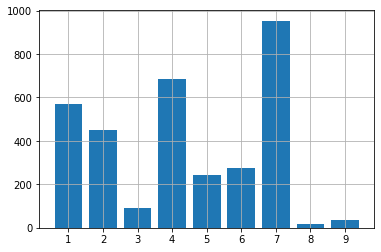

In [6]:
#Is this a balanced or imbalanced dataset?
target = df.Class.value_counts().sort_index()
plt.bar(target.index, target.values)# density = True, bins = np.arange(0.5,10.5), rwidth = 0.8)
plt.grid()
_ = plt.xticks(list(range(1,10)))
#plt.hist(y_dist[column], density = True,bins = np.arange(0.5,10.5), rwidth = 0.8)
#plt.hist(target, density = True)#,bins = np.arange(0.5,10.5))
#target


- This is an imbalanced dataset
- Class '7' is the most frequent class constituting >27% of the data
- Train/test data should be splitted using stratify

In [7]:
## Split the dataset into train, CV and test datasets
X = df.drop(columns = ['ID']) # ['Class', 'ID'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify = y)
print('''Shape of split datasets:
      X_train - {} and y_train - {}, 
      X_test - {} and y_test - {}'''
      .format(X_train.shape,X_test.shape, y_train.shape,y_test.shape,))


Shape of split datasets:
      X_train - (2324, 4) and y_train - (997, 4), 
      X_test - (2324,) and y_test - (997,)


<a id='data_cleaning'></a>
## 1. Data Cleaning
#### Impute Missing values
Text features has missing values
	- The target class for the record with missing text is identified and the most frequent text in that target class is imputed
    

In [8]:
#Filling missing values
#capture the most frequent value for every class
Text_mode = X_train.groupby('Class')['Text'].apply(lambda x: x.value_counts().index[0]).to_dict()
X_train.Text= X_train.apply(lambda x: Text_mode[x.Class] if pd.isnull(x.Text) else x.Text, axis =1)
X_test.Text= X_test.apply(lambda x: Text_mode[x.Class] if pd.isnull(x.Text) else x.Text, axis =1)

In [9]:
print(X_train.Text.isnull().any())
print(X_test.Text.isnull().any())

False
False


<a id='eda'></a>
## 2. Exploratory Data Analysis
<a id='univariate_gene'></a>
##### 2.1 Univariate Analysis: Gene

2.1.1 How many genes are there and how is it distributed?

In [10]:
gene_val_count = X_train.Gene.value_counts(normalize = True)
gene_val_count

BRCA1    0.081756
TP53     0.049484
EGFR     0.043890
BRCA2    0.037866
PTEN     0.037005
           ...   
SRSF2    0.000430
CDK8     0.000430
KMT2B    0.000430
KLF4     0.000430
NCOR1    0.000430
Name: Gene, Length: 240, dtype: float64

In [11]:
print("There are {} unique Genes present in the train dataset".format(gene_val_count.shape[0]))

There are 240 unique Genes present in the train dataset


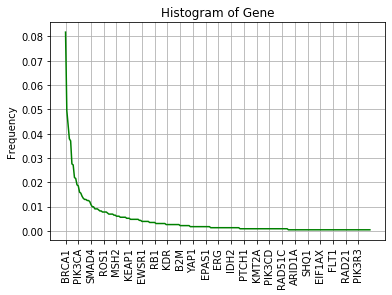

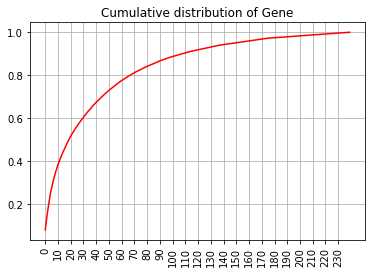

In [12]:
#Distribution of Genes feature
plt.title("Histogram of Gene")
plt.plot(gene_val_count.index, gene_val_count, color = 'g')
# plt.hist(X_train.Gene, bins = 240)
plt.xticks(ticks = list(range(0, len(gene_val_count.index), 10)),rotation = 90)
plt.ylabel("Frequency")
plt.grid()
plt.show()

plt.title("Cumulative distribution of Gene")
plt.plot(range(0,len(gene_val_count)), np.cumsum(gene_val_count), color = 'r')
plt.xticks(ticks = list(range(0, 240, 10)),rotation = 90)
plt.grid()
plt.show()

In [13]:
#gene_val_count.loc[gene_val_count == gene_val_count.quantile(0.8)].index
print("Out of {} genes, 70 genes constitutes >80% of the data".format(gene_val_count.shape[0]))

Out of 240 genes, 70 genes constitutes >80% of the data


- BRCA1 is the most frequent gene in the training dataset
- About 70 genes (30%) of the data constitutes 80% of the data
- From the Gene histogram, it looks like Gene feature follows power law distribution. Let us check with a K-S test

In [14]:
from scipy.stats import probplot, pareto, genpareto
kstest(gene_val_count, 'expon')

KstestResult(statistic=0.9520036740798291, pvalue=6.179442e-317)

Kolgomrov-Smirnov's hypothesis test:Gene feature does not follow exponential distribution as the null hypothesis is rejected with a p-value of zero

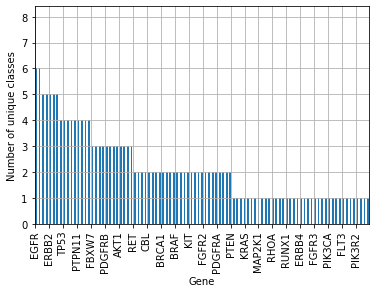

In [15]:
gene_class = X_train.groupby('Gene')['Class'].nunique().sort_values(ascending = False)#.plot()
gene_class.plot(kind = 'bar')
plt.xticks(ticks = list(range(0, len(gene_val_count.index), 10)),rotation = 90)
plt.ylabel("Number of unique classes")
plt.grid()
plt.show()

In [16]:
print(f"Among the {gene_class.shape[0]} unique genes, {(gene_class[gene_class == 1].shape[0]/gene_class.shape[0])*100}% is categorized into one unique gene mutation class type")
print("Thus, gene feature alone can classify these genes correctly")

Among the 240 unique genes, 40.833333333333336% is categorized into one unique gene mutation class type
Thus, gene feature alone can classify these genes correctly


2.1.2 How stable is the gene feature across train, cv and test datasets?

In [17]:
## How stable is Gene feature?
print("Train:", sum(X_train.Gene.isin(set(X_train.Gene)))/X_train.Gene.shape[0])
print("Test:", sum(X_test.Gene.isin(set(X_train.Gene)))/X_test.Gene.shape[0])

Train: 1.0
Test: 0.9729187562688064


There is ~97% of data overlap between train and test data and thus this is a stable feature

In [18]:
### Data transformation classes and functions
class ColumnsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [19]:
scientific_stop_words = {'et', 'al', 'figure', 'fig', 'abstract', 'background', 'go to', 'analyze', 'results',
 'materials','methods', 'table', 'reviewed', 'procedures', 'experimental', 'introduction',
 'author', 'information', 'show', 'find', 'found', 'study', 'result', 'conclusion', 'method', 
 'analysis', 'describe', 'supplementary', 'supplemental', 'shown', 'shows', 'using', 'table',
 'therefore', 'whether', 'reported', 'described', 'ref', 'discussion', 'references', 'acknowledge',
'determined', 'thus', 'performed', 'performing', 'follow', 'follows', 'following', 'examined', 
 'suggesting', 'observation', 'suggests', 'presents', 'presented', 'defined', 'suggest', 'also',
'figures', 'identified', 'validated', 'one', 'might', 'including', 'analyzed', 'recurrently',
'upon', 'however', 'suggest', 'showed', 'suggested', 'indicate', 'indicated', 'indicates',
'studies', 'used', 'observed', 'may', 'although', 'respectively', 'two', 'three', 'would', 
'published', 'reveal', 'revealed', 'display', 'displayed', 'demonstrated', 'since', 'report',
 'exhibited', 'given', 'expressed', 'obtained','since', 'resulting','whereas', 'download',
                 'schematic view', 'research', 'article', 'nature', 'vol',  'powerpoint', '270k'}

class TextPreprocessing():
    def __init__(self,cols=None):
        self.cols = cols

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        '''Removes references, weblinks and texts: figures # and tables'''       
        lemma = WordNetLemmatizer()
#        text_series = pd.Series(X.copy())
        text_series = X.ravel().copy()

#        for index, text_data in text_series.iteritems():
        for index, text_data in enumerate(text_series):
            if type(text_data) == str:                
                stop_words = set(stopwords.words('English'))
                stop_words.update(scientific_stop_words)
                text_data = re.sub(r'\[\d{1,2}\]', '', text_data) #remove numbered references with []
                text_data = re.sub(r'Table\s\w{0,3}', '', text_data) #removes references to tables
                text_data = re.sub(r'Figure\s\w{0,5}', '', text_data) #removes references to figures
                text_data = re.sub(r'Fig\.\s\w{0,5}', '', text_data) #removes references to figures
                text_data = re.sub(r'\(\d{1,2}\)', '', text_data) #remove numbered references with ()
                text_data = re.sub(r'\(\d{0,2},\s*\d{0,2}\)', '', text_data) #remove numbered references with ()
                ##remove links
                text_data = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text_data)
                text_data = text_data.lower()
                text_data = re.sub(r'[^a-zA-Z0-9+]', ' ', text_data)
                text_data = re.sub(r'\\b\d+\\b', ' ', text_data) # remove all number only words
                text_data = re.sub(r'\s+',' ', text_data)
    
                text = ""
                for word in text_data.split():
                    if word not in stop_words:
                        text += lemma.lemmatize(word) + " "
                text_series[index] = text
        return text_series

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
### Preprocessing via scispacy
nlp_spacy = en_core_sci_sm.load()
w2vec = {} ## gets the word to vector of all the tokens
def scispacy_preprocesser(doc):
    '''Returns preprocessed, tokenized features from the given documents'''
    doc = nlp_spacy(doc)
    spacy_tokens = doc.ents
    ## gets the word to vector of all the tokens
    w2vec.update({str(tok):tok.vector for tok in spacy_tokens if tok not in w2vec})
    return [token.text for token in spacy_tokens]

In [20]:
#separate text and other features
cat_attributes = ['Gene', 'Variation']
text_attributes = ['Text']

pipeline_cat = Pipeline([('attributes',ColumnsSelector(cat_attributes)),
                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore')),                         
                         ('standardization', StandardScaler(with_mean = False))]) 
pipeline_text = Pipeline([('attributes',ColumnsSelector(text_attributes)),
                          ('preprocessing', TextPreprocessing()),#])#,
                            ('vectorize', CountVectorizer(analyzer=scispacy_preprocesser, min_df =3, max_df =150)),
                            ('normalize', Normalizer())])   
                       
pipeline_features = FeatureUnion(transformer_list=[("categorical_features", pipeline_cat),
                                               ("text_feature", pipeline_text)])

In [21]:
train_data = pipeline_features.fit_transform(X_train, y_train)
test_data = pipeline_features.transform(X_test)

In [24]:
#train_data.toarray()
pipeline_features.get_params()['categorical_features']['onehotencoding'].categories_

[array(['ABL1', 'ACVR1', 'AGO2', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'APC',
        'AR', 'ARAF', 'ARID1A', 'ARID1B', 'ARID5B', 'ATM', 'ATR', 'ATRX',
        'AURKA', 'AURKB', 'AXIN1', 'AXL', 'B2M', 'BAP1', 'BCL10', 'BCL2',
        'BCL2L11', 'BCOR', 'BRAF', 'BRCA1', 'BRCA2', 'BRD4', 'BRIP1',
        'BTK', 'CARD11', 'CARM1', 'CASP8', 'CBL', 'CCND1', 'CCND2',
        'CCND3', 'CCNE1', 'CDH1', 'CDK12', 'CDK4', 'CDK6', 'CDK8',
        'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CHEK2', 'CIC',
        'CREBBP', 'CTCF', 'CTLA4', 'CTNNB1', 'DDR2', 'DICER1', 'DNMT3A',
        'DNMT3B', 'EGFR', 'EIF1AX', 'ELF3', 'EP300', 'EPAS1', 'ERBB2',
        'ERBB3', 'ERBB4', 'ERCC2', 'ERCC3', 'ERCC4', 'ERG', 'ESR1', 'ETV1',
        'ETV6', 'EWSR1', 'EZH2', 'FAM58A', 'FANCA', 'FANCC', 'FAT1',
        'FBXW7', 'FGF4', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FLT1',
        'FLT3', 'FOXA1', 'FOXL2', 'FOXO1', 'FOXP1', 'FUBP1', 'GATA3',
        'GLI1', 'GNA11', 'GNAQ', 'GNAS', 'H3F3A', 'HLA-A', 'HLA-B',
      

In [25]:
print("Shape of train data",train_data.shape)
print("Shape of test data",train_data.shape)

Shape of train data (2324, 101540)
Shape of test data (2324, 101540)


In [26]:
pipeline_features.transformer_list

[('categorical_features', Pipeline(memory=None,
           steps=[('attributes',
                   ColumnsSelector(attribute_names=['Gene', 'Variation'])),
                  ('onehotencoding',
                   OneHotEncoder(categories='auto', drop=None,
                                 dtype=<class 'numpy.float64'>,
                                 handle_unknown='ignore', sparse=True)),
                  ('standardization',
                   StandardScaler(copy=True, with_mean=False, with_std=True))],
           verbose=False)), ('text_feature', Pipeline(memory=None,
           steps=[('attributes', ColumnsSelector(attribute_names=['Text'])),
                  ('preprocessing',
                   <__main__.TextPreprocessing object at 0x1c25462050>),
                  ('vectorize',
                   CountVectorizer(analyzer=<function scispacy_preprocesser at 0x1c24d2b320>,
                                   binary=False, decode_error='strict',
                                   dt

In [27]:
text_corpus = pipeline_features.get_params()['text_feature']['vectorize'].vocabulary_
#text_corpus = pipeline_features.get_params()['vectorize'].vocabulary_
max(text_corpus.values())

99193

In [28]:
pipeline_features.get_params()['text_feature']['vectorize'].vocabulary_

{'cancer harbor': 11836,
 'somatic point mutation': 85202,
 'genetic basis': 37891,
 'korean': 49789,
 'surgical specimen': 88396,
 'transcriptome sequencing': 91842,
 'somatic mutation cancer': 85177,
 'gene egfr': 36737,
 'braf pik3ca': 10187,
 'chimeric tyrosine kinase': 17182,
 'ros1': 80347,
 'pdgfra': 69043,
 'proto oncogene': 74811,
 'smoking': 84857,
 'history': 43133,
 'low dose': 53016,
 'computerized tomography': 20019,
 'histopathologic': 43094,
 'reclassification': 77725,
 'chemotherapeutic agent': 17083,
 'crizotinib': 22393,
 'eml4': 29824,
 'ethnic group': 31231,
 'gazdar': 36169,
 'molecular alteration': 57893,
 'surveyed': 88437,
 'advance': 1973,
 'genomic technology': 38577,
 'rna sequencing': 80263,
 'cancer sample': 11931,
 'primary lung adenocarcinoma': 72585,
 'cancer tissue': 11971,
 'screening test': 81878,
 'transcriptome': 91821,
 'lung tissue': 53404,
 'exome capture': 31619,
 'g719a': 35770,
 'egfr kras': 29252,
 'q61l': 75674,
 'h1047r': 40669,
 'schmidt'

In [29]:
### Analysis of text frequency in the corpus    

def text_dictionary(text_feature_name, vectorized_train_X):
    '''Returns a dictionary of all the tokens from the Text feature training data with their 
    frequency or TF-IDF values'''
    return dict(zip(text_feature_name,vectorized_train_X.sum(axis = 0).A1))

def top_x_features_plot(text_feature_name, vectorized_train_X, n):
    '''Plots the top n frequent tokens found in the text corpus '''
    text_dict = text_dictionary(text_feature_name, vectorized_train_X)
    text_frequency = pd.DataFrame.from_dict(text_dict, orient ='index').reset_index()
    text_frequency.rename({'index': 'word', 0:'frequency'}, axis =1, inplace = True)
    text_frequency_sorted = text_frequency.sort_values(by = 'frequency', ascending = False)[:n]
    plt.figure(figsize=(15,10))
    plt.bar(text_frequency_sorted.word, text_frequency_sorted.frequency)
    _ = plt.xticks(rotation = 90)
    plt.grid()
    plt.show()
    return text_frequency_sorted.word
    
def word_cloud_plot(text_feature_name, vectorized_train_X):
    '''Plots the word cloud plot of the given text'''
    text_dict = text_dictionary(text_feature_name, vectorized_train_X)
    # Create the wordcloud object
    wordcloud = WordCloud(font_path = 'Arial',max_words = 45000, width = 1600, height = 800, 
                          margin =0, include_numbers=True, 
                          colormap = 'Set1').generate_from_frequencies(text_dict)
    # Display the generated image:
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
def top_n_words_per_target_class(text_feature_name, vectorized_train_X, n):
    '''Returns the n tookens with the highest frequency grouped by the target class'''
    vect_text_df = pd.DataFrame(data = vectorized_train_X, columns = text_feature_name)
    vect_text_df['Target'] = y_train.reset_index(drop = True)
    vect_text_df_sum = vect_text_df.groupby('Target').sum()

    return (pd.DataFrame({n: vect_text_df_sum.T[col].nlargest(20).index.tolist() 
                  for n, col in enumerate(vect_text_df_sum.T)}).T)

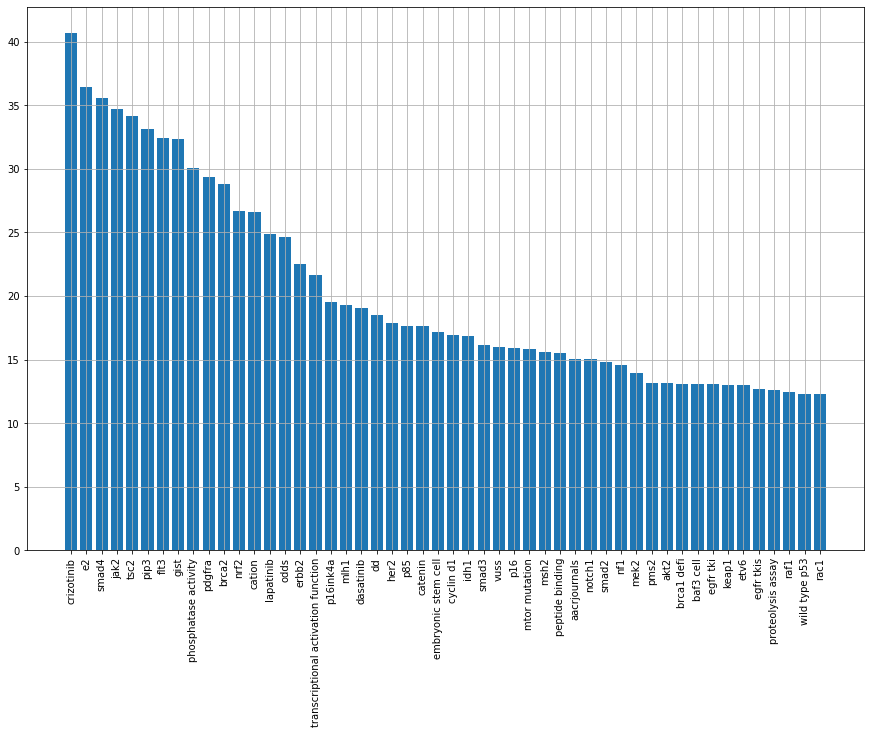

The top 50 words and their frequencies are 22393                             crizotinib
28328                                     e2
84589                                  smad4
48268                                   jak2
93160                                   tsc2
70800                                   pip3
34095                                   flt3
38921                                   gist
70085                   phosphatase activity
69043                                 pdgfra
10671                                  brca2
63901                                   nrf2
13351                                 cation
50403                              lapatinib
65048                                   odds
30729                                  erbb2
91640    transcriptional activation function
66544                               p16ink4a
57509                                   mlh1
24048                              dasatinib
24561                                     dd
42066       

In [30]:
### Top 50 words in the corpus

text_features = pipeline_features.get_params()['text_feature']['vectorize'].get_feature_names()
print("The top 50 words and their frequencies are", top_x_features_plot(text_features, train_data[:,train_data.shape[1]- len(text_features):], 50))

### Word cloud plot of all the words in the corpus

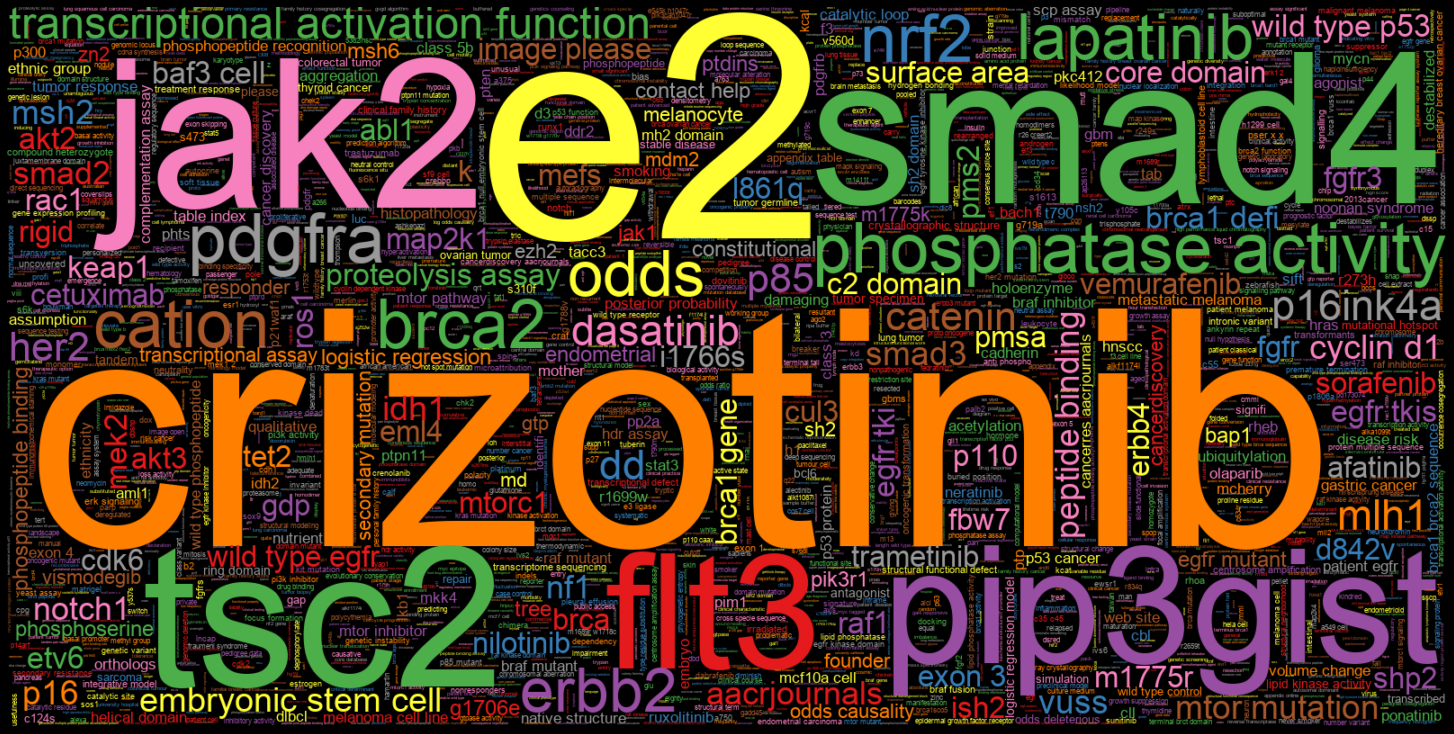

In [31]:
word_cloud_plot(text_features, train_data[:,train_data.shape[1]- len(text_features):])

### Top 20 tokens per class

In [32]:
top_n_words_per_target_class(text_features, train_data[:,train_data.shape[1]- len(text_features):].toarray(), 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,tsc2,smad4,transcriptional activation function,smad3,smad2,peptide binding,wild type p53,msh2,brca2,mlh1,proteolysis assay,ptp,core domain,pp2a,p85,rac1,m1775r,aggregation,pmsa,rigid
1,gist,crizotinib,nilotinib,ros1,dasatinib,lapatinib,notch1,jak2,egfr tki,egfr tkis,cyclin d1,erbb2,secondary mutation,afatinib,pdgfrb,wild type egfr,l861q,vemurafenib,notch,cetuximab
2,flt3,crizotinib,mtor mutation,pdgfra,pip3,cation,hdr assay,alka1099t,alkf1174l,alkt1087i,e2,r834q,tsc2,alkf1174i,embryonic stem cell,mtorc1,s451f,dd,agonist,alkm1166r
3,pip3,phosphatase activity,p16ink4a,smad4,dd,tsc2,e2,p16,nf1,mlh1,smad3,ptdins,cul3,msh2,nrf2,fbw7,catalytic loop,cation,pms2,cdk6
4,cation,embryonic stem cell,brca2,brca1 defi,aacrjournals,odds,peptide binding,transcriptional activation function,vuss,idh1,proteolysis assay,cancerdiscovery,m1775r,pmsa,crizotinib,cancer discovery,complementation assay,olaparib,elf3,pms2
5,e2,odds,brca2,vuss,jak2,lapatinib,logistic regression,ruxolitinib,brca,brca1 brca2 sequence,appendix table,zn2,odds deleterious,logistic regression model,tet2,histopathology,erbb2,i1766s,fedratinib,ethnic group
6,crizotinib,flt3,pdgfra,gist,jak2,nrf2,catenin,her2,cyclin d1,dasatinib,mtor mutation,akt2,lapatinib,erbb2,baf3 cell,eml4,jak1,d842v,wild type egfr,egfr tkis
7,bcor,idh2,idh1,h3f3a,atrx,shp2,h3,cetuximab,lapatinib,dna methylation,akt2,gbm,rock,cpg,panitumumab,paediatric,daxx,neratinib,dnmt3b,rac1
8,ezh2,idh1,md,cll,junction,idh2,pre mrna,nalm,uveal melanoma,py tract,dox,crnde,srsf2,myelodysplasia,mxsf3b1wt,splice junction,sf1,prpf40b,wild type control,cryptic ag


In [33]:
from sklearn.metrics import make_scorer
def spot_check_model(model, trainx, trainy, score = 'neg_log_loss'):
    '''Returns the mean CV score of given model. Performs cross validation with 5 splits with 3 repeats'''
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    model_score = cross_val_score(model, trainx, trainy, scoring = score, cv=cv)
    return model_score

##Grid search for hyperparameter tuning
def grid_search_cv(model, params, trainx, trainy):
#    logloss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
#Added to overcome SVM predict probability limitation
    calibrated_model = CalibratedClassifierCV(base_estimator=model, method='isotonic')
    grid_cv = GridSearchCV(calibrated_model, param_grid=params, scoring='neg_log_loss', cv = 5, return_train_score = True)
    grid_cv.fit(trainx,trainy)
    return grid_cv, grid_cv.best_score_

In [85]:
## Classification matric functions

# def classification_kpi(x, truey, model):
#     '''Returns the logistic loss and confusion matrix of the model'''
#     y = model.predict(x)
#     y_prob = model.predict_proba(x)
#     return (log_loss(truey, y_prob), confusion_matrix(truey, y), precision_recall_fscore_support(truey, y))   

def plot_cm_precision_recall_curves(cm):
    '''Returns seaborn heatmap plots of confusion matrix, precision and recall values'''
    plots = ['Confusion Matrix', 'Precision', 'Recall']
    classification_metric_heatmap(cm, "Confusion Matrix")
    classification_metric_heatmap(cm/cm.sum(axis=0), "Precision")
    classification_metric_heatmap(cm/cm.sum(axis=1).reshape(9,1), "Recall")
        
def classification_metric_heatmap(data, title):
    '''Returns seaborn heatmap of given data'''
    tick_labels = range(1,10)
    plt.title(title)
    sns.heatmap(data, cmap = 'Blues', annot = True, xticklabels=tick_labels, yticklabels=tick_labels)
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    plt.show()

def pipe_grid_search_results(classifier, train_x_data, y_train, test_x_data, y_test):
#def pipe_grid_search_results(classifier, test_x_data, y_test):
    '''Returns the following metrics on test data:
    Accuracy, Precision, Recall, Confusion Matrix, ROC-AUC, PR-AUC, F1-score and
    Best hyperparameters of the model. Also returns ROC-AUC of train and validation data'''
    
    model = CalibratedClassifierCV(classifier, cv='prefit', method = 'isotonic')
    model.fit(train_x_data, y_train)
     
    preds = model.predict(test_x_data)
    probs = model.predict_proba(test_x_data)
    print("Log loss of Test data:", log_loss(y_test, probs))
    print("Model accuracy: {:.4f}%".format(100*(accuracy_score(y_test, preds))))
    plot_cm_precision_recall_curves(confusion_matrix(y_test, preds))
    return None
    
    # Run again
def model_evaluation(model, parameters, trainx, trainy, testx, testy):
    '''Evaluates the given model and returns the log loss scores, confusion matrix, precision
    and recall scores'''
    fit, score= grid_search_cv(model, parameters, trainx, trainy)
    print("Results:")
    print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
    print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
    pipe_grid_search_results(fit, trainx, trainy, testx, testy)
    return fit    

<a id='model'></a>
### 3. Modelling of data
<a id='ohe-count'></a>
#### 3.1 Onehot encoded gene and variation features; and count vectorized text feature

In [35]:
### dummy model
dummy = DummyClassifier()
print("ROC-AUC score from dummy model is: {:0.2f}".format(np.mean(spot_check_model(dummy, train_data, y_train))))

ROC-AUC score from dummy model is: -28.11


Results:
Logloss of train data:  0.12926379562015136
Logloss of CV data:  1.191573865230769
Log loss of Test data: 8.689639271398333
Model accuracy: 0.6028%


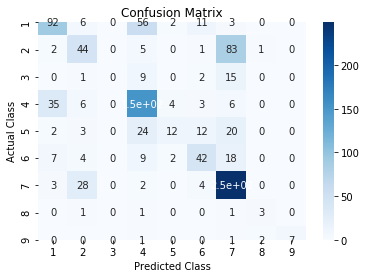

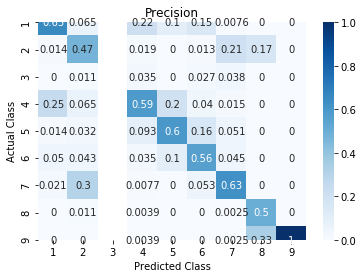

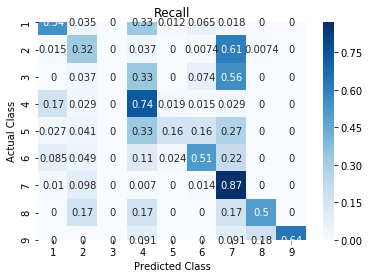

In [60]:
## Model 1: Logistic regression
logistic_regression = SGDClassifier(loss = 'log', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
fit, score= grid_search_cv(logistic_regression, parameters, train_data, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data, y_train, test_data, y_test)


Results:
Logloss of train data:  0.14903486269631833
Logloss of CV data:  1.1974795894007775
Log loss of Test data: 6.000426119044027
Model accuracy: 0.5868%


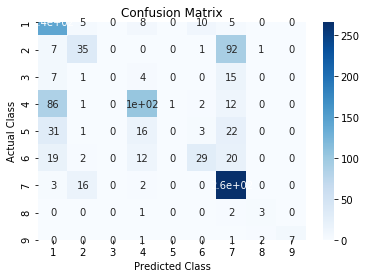

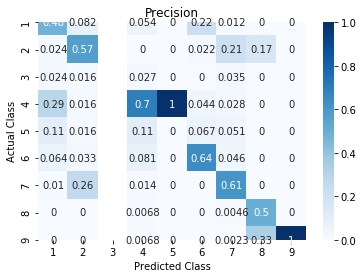

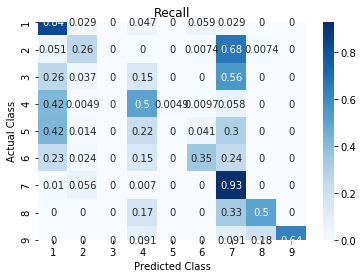

In [64]:
## Model 2: SVM
logistic_regression = SGDClassifier(loss = 'hinge', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
fit, score= grid_search_cv(logistic_regression, parameters, train_data, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data, y_train, test_data, y_test)

Results:
Logloss of train data:  0.21628551143792393
Logloss of CV data:  1.2052477980869143
Log loss of Test data: 6.022880682215578
Model accuracy: 57.0712%


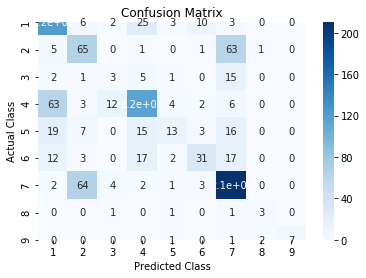

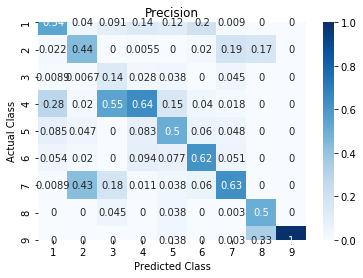

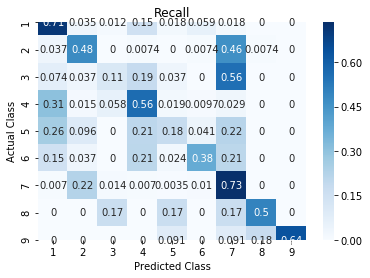

In [79]:
## Model 3: Multinomial Naive Bayes
mnb = MultinomialNB()
parameters = {'base_estimator__alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
fit, score= grid_search_cv(mnb, parameters, train_data, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data, y_train, test_data, y_test)


Results:
Logloss of train data:  0.5934558510596993
Logloss of CV data:  1.2265729699478367
Log loss of Test data: 6.13960958876522
Model accuracy: 0.6499%


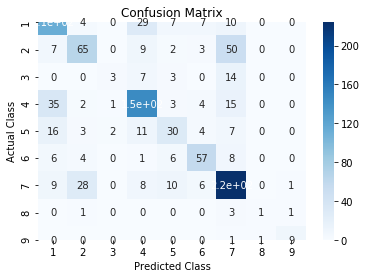

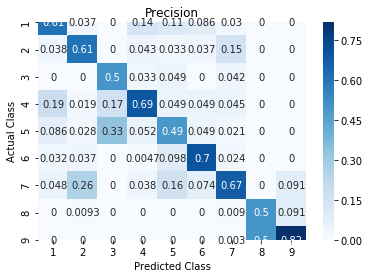

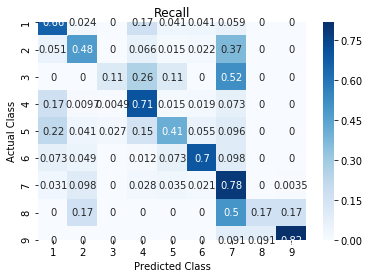

In [63]:
## Model 3: Random Forest
rf = RandomForestClassifier(class_weight='balanced')
parameters = {'base_estimator__n_estimators':[100, 200, 500, 1000], 'base_estimator__max_depth':[5,10, 15]}
fit, score= grid_search_cv(rf, parameters, train_data, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data, y_train, test_data, y_test)

<a id='te-count'></a>
### Feature Engineered Gene and Variation features:
#### 3.2 Target encoded Gene and variation feature with count vectorized text features

In [67]:
class TargetEncoding():
    '''Returns the response encoded numerical array of the given feature. Converts every
    category in a feature into a 9-dimensional vector.
    
    Logic used: Conditional probability with Laplace smoothing
    For gene feature:     
    9-dimensional array containing probability for every class:
    [P(class=1|gene'A') = P(class=1 and gene'A') /P(gene'A'),
    P(class=2|gene'A') = P(class=2 and gene'A') /P(gene'A'),
    .
    .
    P(class=9|gene'A') = P(class=9 and gene'A') /P(gene'A')]
    Laplace smoothing included to avoid zero probability
    '''
    
    def __init__(self,cols=None, alpha =1, k = 9, features = None):
        self.cols = cols
        self.alpha = alpha
        self.k = k
        self.features = features

    def fit(self,X,y):
        return self

    def transform(self,X,y):
        if not self.features:
            self.features = []
            for i in range(X.shape[1]):
                class_vector = np.zeros(9)
                feat_dict = {}

                cat_unique, cat_counts = np.unique(X[:,i],return_counts = True) ## P(Gene)
                prior = dict(zip(cat_unique, cat_counts))

                for cat in cat_unique:
                    for clas in np.unique(y.values):
                        index = np.argwhere(y.values == clas)
                        class_vector[clas-1] = (np.sum(X[:,i][index] == cat) + self.alpha)/(prior[cat] + self.alpha*self.k)
                    feat_dict[cat] = class_vector
                self.features.append(feat_dict)      

            return np.hstack((np.array([self.features[0][g] for g in X[:,0]]), 
                              np.array([self.features[1][v] for v in X[:,1]])))
        else:
            return np.hstack((np.array([self.features[0][g] if g in self.features[0] else np.zeros(9) for g in X[:,0]]), 
                              np.array([self.features[1][v] if v in self.features[1] else np.zeros(9) for v in X[:,1]])))
        
    def fit_transform(self,X,y):
        return self.fit(X,y).transform(X,y)

In [68]:
from joblib import Parallel, delayed
from scipy import sparse

class PipelineModified(Pipeline):
    
    def _transform(self, X, y):
        Xt = X
        for _, transform_name, transform in self._iter():
            if transform_name != "normalize":
                Xt = transform.transform(Xt,y)
            else:
                Xt = transform.transform(Xt)
        return Xt
    
def _transform_one(name, transformer, X, y, weight, **fit_params):
    if name == "categorical_features":
        res = transformer.transform(X,y)
    else:
        res = transformer.transform(X)
        # if we have a weight for this transformer, multiply output
    if weight is None:
        return res
    return res * weight
    
class FeatureUnionModified(FeatureUnion,):
    def transform(self, X, y=None):
        """Transform X separately by each transformer, concatenate results.
        Parameters
        ----------
        X : iterable or array-like, depending on transformers
            Input data to be transformed.
        Returns
        -------
        X_t : array-like or sparse matrix of \
                shape (n_samples, sum_n_components)
            hstack of results of transformers. sum_n_components is the
            sum of n_components (output dimension) over transformers.
        """
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(name, trans, X, y=None, weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = np.hstack(Xs)
        return Xs

In [69]:
### SK learn pipeline for target encoded Gene and variation feature
cat_attributes = ['Gene', 'Variation']
text_attributes = ['Text']

pipeline_cat_target_encd = PipelineModified([('attributes',ColumnsSelector(cat_attributes)),
                         ('targetencoding', TargetEncoding()),                         
                        ('normalize', Normalizer())]) 

pipeline_text = Pipeline([('attributes',ColumnsSelector(text_attributes)),
                         ('preprocessing', TextPreprocessing()),
                         ('vectorize', CountVectorizer(analyzer=scispacy_preprocesser, min_df =3, max_df =150)),
                         ('normalize', Normalizer())])   

pipeline_features_target_encd = FeatureUnionModified(transformer_list=[("categorical_features", pipeline_cat_target_encd),
                                               ("text_feature", pipeline_text)])


In [70]:
train_data_te = pipeline_features_target_encd.fit_transform(X_train, y_train)
test_data_te = pipeline_features_target_encd.transform(X_test, y_test)

In [155]:
train_data_te.shape

(2324, 99212)

Results:
Logloss of train data:  0.6219046969181381
Logloss of CV data:  1.1799129835894397
Log loss of Test data: 2.8346922261507763
Model accuracy: 63.3902%


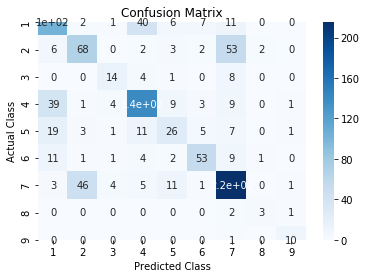

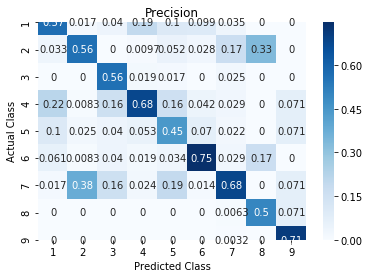

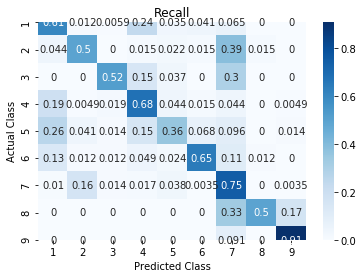

In [71]:
## Model 1: Logistic regression
logistic_regression = SGDClassifier(loss = 'log', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
fit, score= grid_search_cv(logistic_regression, parameters, train_data_te, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data_te, y_train, test_data_te, y_test)

Results:
Logloss of train data:  0.5959529521066512
Logloss of CV data:  1.2316356696064785
Log loss of Test data: 4.019277435909685
Model accuracy: 63.8917%


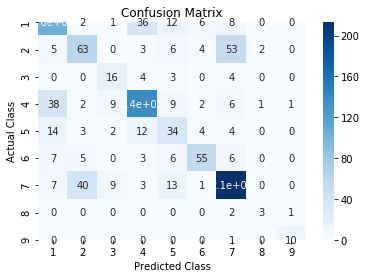

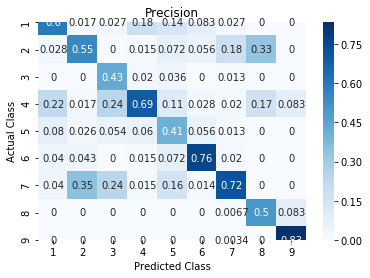

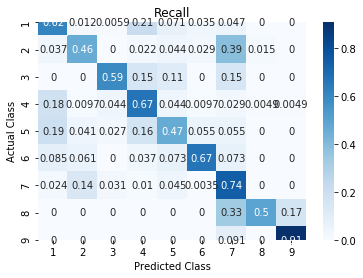

In [80]:
## Model 2: SVM
svm = SGDClassifier(loss = 'hinge', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
fit, score= grid_search_cv(svm, parameters, train_data_te, y_train)

print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data_te, y_train, test_data_te, y_test)

Results:
Logloss of train data:  0.7894162627943901
Logloss of CV data:  1.261985423218496
Log loss of Test data: 1.4298015943347446
Model accuracy: 58.0742%


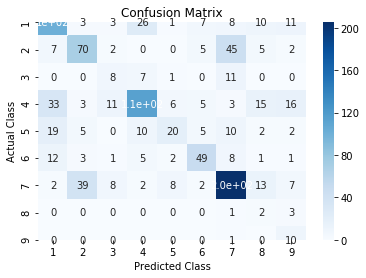

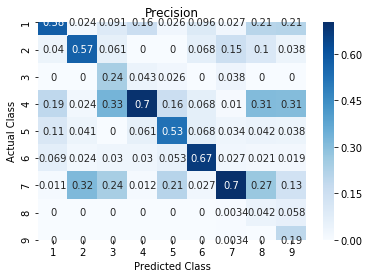

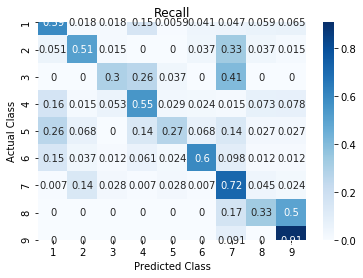

In [81]:
## Model 3: Multinomial Naive Bayes
mnb = MultinomialNB()
parameters = {'base_estimator__alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
fit, score= grid_search_cv(mnb, parameters, train_data_te, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data_te, y_train, test_data_te, y_test)


Results:
Logloss of train data:  0.706341587768906
Logloss of CV data:  1.27605005947472
Log loss of Test data: 2.1226060736402044
Model accuracy: 63.8917%


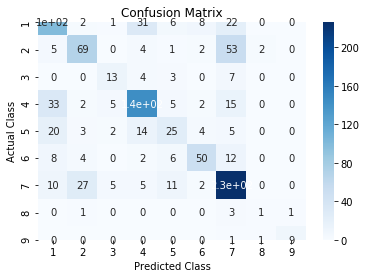

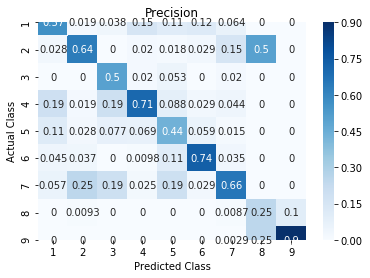

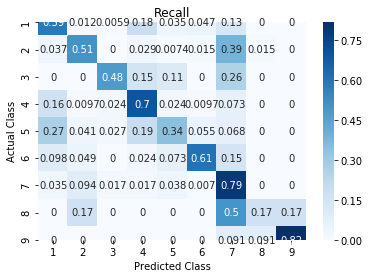

In [74]:
## Model 4: Random Forest

rf = RandomForestClassifier(class_weight='balanced')
parameters = {'base_estimator__n_estimators':[100, 200, 500, 1000], 'base_estimator__max_depth':[5,10, 15]}
fit, score= grid_search_cv(rf, parameters, train_data_te, y_train)
print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data_te, y_train, test_data_te, y_test)

<a id='te-tfidf'></a>
### 3.3 Target encoded Gene and Variation features with tf-idf vectorized text feature

In [75]:
### SK learn pipeline for target encoded Gene and variation feature
cat_attributes = ['Gene', 'Variation']
text_attributes = ['Text']

pipeline_cat_target_encd = PipelineModified([('attributes',ColumnsSelector(cat_attributes)),
                         ('targetencoding', TargetEncoding()),                         
                        ('normalize', Normalizer())]) 

pipeline_text_tf_idf = Pipeline([('attributes',ColumnsSelector(text_attributes)),
                         ('preprocessing', TextPreprocessing()),
                         ('tfidfvectorize', TfidfVectorizer(analyzer=scispacy_preprocesser, min_df =3)),
                        ('normalize', Normalizer())])   

pipeline_features_target_encd_tfidf = FeatureUnionModified(transformer_list=[("categorical_features", pipeline_cat_target_encd),
                                               ("text_feature", pipeline_text_tf_idf)])


In [76]:
train_data_te_tfidf = pipeline_features_target_encd_tfidf.fit_transform(X_train, y_train)
test_data_te_tfidf = pipeline_features_target_encd_tfidf.transform(X_test, y_test)

Results:
Logloss of train data:  0.560025567137561
Logloss of CV data:  1.1350900900243766
Log loss of Test data: 4.491699751402355
Model accuracy: 64.7944%


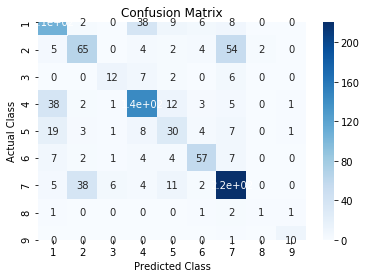

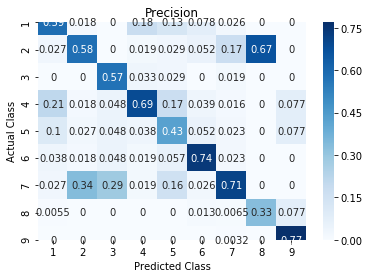

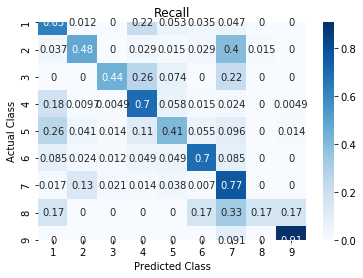

In [77]:
## Model 1: Logistic regression

logistic_regression = SGDClassifier(loss = 'log', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
fit, score= grid_search_cv(logistic_regression, parameters, train_data_te_tfidf, y_train)

print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data_te_tfidf, y_train, test_data_te_tfidf, y_test)


Results:
Logloss of train data:  0.579486902624933
Logloss of CV data:  1.1751995671759228
Log loss of Test data: 3.849027018759288
Model accuracy: 65.0953%


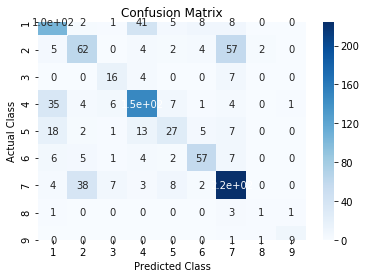

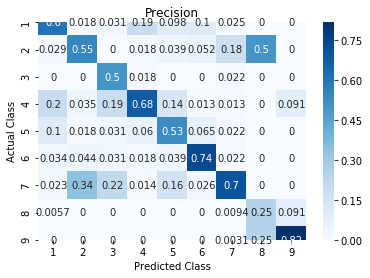

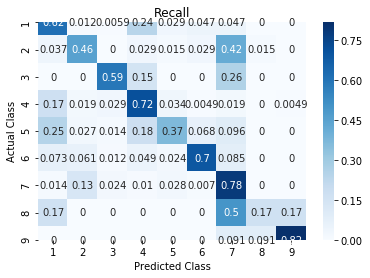

In [78]:
## Model 2: SVM
svm = SGDClassifier(loss = 'hinge', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
fit, score= grid_search_cv(svm, parameters, train_data_te_tfidf, y_train)

print("Results:")
print("Logloss of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
print("Logloss of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
pipe_grid_search_results(fit, train_data_te_tfidf, y_train, test_data_te_tfidf, y_test)

Results:
Logloss of train data:  0.6169578456241356
Logloss of CV data:  1.2083223040920006
Log loss of Test data: 2.8570069432719385
Model accuracy: 65.2959%


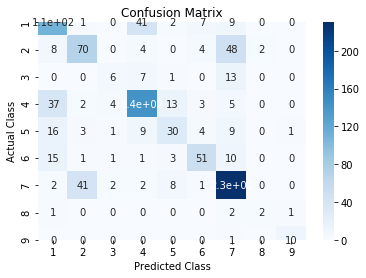

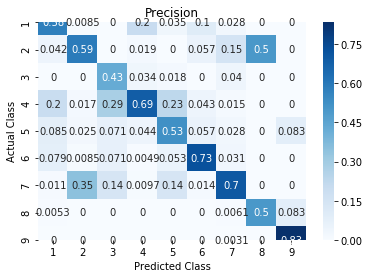

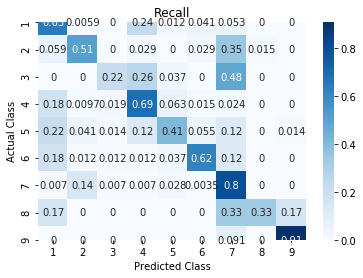

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1.0,
                                                                           class_prior=None,
                                                                           fit_prior=True),
                                              cv=None, method='isotonic'),
             iid='deprecated', n_jobs=None,
             param_grid={'base_estimator__alpha': [1e-05, 0.0001, 0.001, 0.1, 1,
                                                   10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_log_loss', verbose=0)

In [86]:
## Model 3: Multinomial Naive Bayes
mnb = MultinomialNB()
parameters = {'base_estimator__alpha':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
model_evaluation(mnb, parameters, train_data_te_tfidf, y_train, test_data_te_tfidf, y_test)

Results:
Logloss of train data:  0.6361397022196
Logloss of CV data:  1.1836769071643225
Log loss of Test data: 1.5931486042245828
Model accuracy: 65.2959%


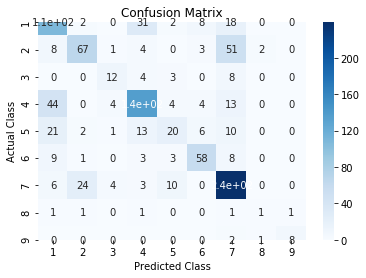

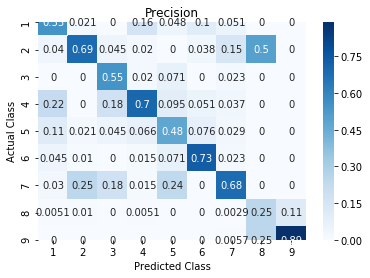

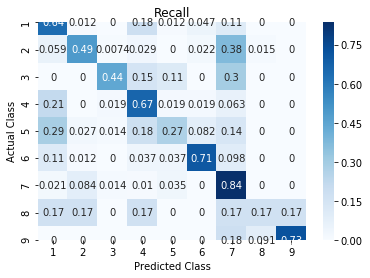

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight='balanced',
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    max_samples=None,
                                                                                    min_impurity_decrease=0.0,
                               

In [105]:
## Model 4: Random Forest
rf = RandomForestClassifier(class_weight='balanced')
parameters = {'base_estimator__n_estimators':[100, 200, 500, 1000], 'base_estimator__max_depth':[5,10, 15]}
model_evaluation(rf, parameters, train_data_te_tfidf, y_train, test_data_te_tfidf, y_test)

Results:
Logloss of train data:  0.6988342244170147
Logloss of CV data:  1.2380287424128817
Log loss of Test data: 1.7076182771016046
Model accuracy: 61.7854%


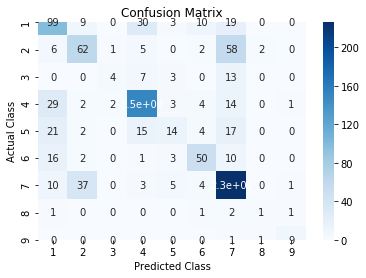

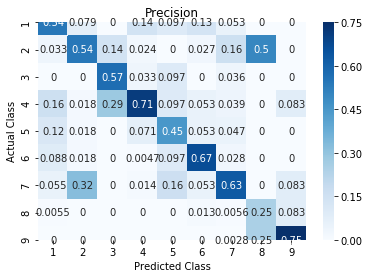

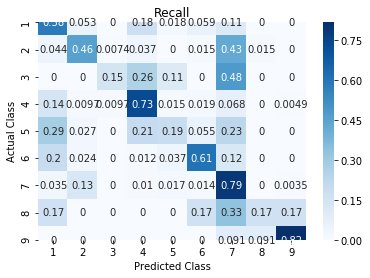

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                                                  ccp_alpha=0.0,
                                                                                  class_weight='balanced',
                                                                                  criterion='gini',
                                                                                  max_depth=None,
                                                                                  max_features='auto',
                                                                                  max_leaf_nodes=None,
                                                                                  max_samples=None,
                                                                                  min_impurity_decrease=0.0,
                                                

In [106]:
## Model 4: Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
extrees = ExtraTreesClassifier(class_weight='balanced')
parameters = {'base_estimator__n_estimators':[100, 200, 500, 1000], 'base_estimator__max_depth':[5,10, 15]}
model_evaluation(extrees, parameters, train_data_te_tfidf, y_train, test_data_te_tfidf, y_test)

<a id='te-w2vec'></a>
#### 3.4 Target encoded Gene and Variation features with TF_IDF weighted word2vector

In [90]:
### Class definition for tf-idf weighted vector
w2vec={}
class TfidfWeightedWord2Vec(object):
    '''Converts collection of raw documents into TF-IDF weighted word2vec. Utilizes Scispacy
    package for tokenization and to obtain word2vector. Word vectors have 96 dimensions'''
    
    def __init__(self):
        self.w2vec_array = None
        
    def fit(self, X, y):
        self.tfidf = TfidfVectorizer(analyzer=scispacy_preprocesser, min_df = 3, max_df = 150)
        self.tfidf.fit(X)

        self.w2vec_array = np.zeros((len(self.tfidf.vocabulary_),96))
        for vocab_term,index in self.tfidf.vocabulary_.items():
            self.w2vec_array[index,:]=w2vec[vocab_term]
        return self

    def transform(self, X):
        X = self.tfidf.transform(X)
        return (X*self.w2vec_array)/(np.sum(X, axis =1).reshape(X.shape[0],1))
# reference: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [91]:
### Pipeline updated with tfidf word2vector

cat_attributes = ['Gene', 'Variation']
text_attributes = ['Text']

pipeline_cat_target_encd = PipelineModified([('attributes',ColumnsSelector(cat_attributes)),
                         ('targetencoding', TargetEncoding()),                         
                        ('normalize', Normalizer())]) 

pipeline_text_tfidfw2v = Pipeline([('attributes',ColumnsSelector(text_attributes)),
                         ('preprocessing', TextPreprocessing()),
                         ('tfidfweightedw2v', TfidfWeightedWord2Vec()),
                        ('normalize', Normalizer())])   

pipeline_features_target_encd_tfidfw2v = FeatureUnionModified(transformer_list=[("categorical_features", pipeline_cat_target_encd),
                                               ("text_feature", pipeline_text_tfidfw2v)])


In [92]:
train_data_te_tfidfw2v = pipeline_features_target_encd_tfidfw2v.fit_transform(X_train, y_train)
test_data_te_tfidfw2v = pipeline_features_target_encd_tfidfw2v.transform(X_test, y_test)

In [156]:
train_data_te_tfidfw2v.shape

(2324, 114)

Results:
Logloss of train data:  1.3967556255435185
Logloss of CV data:  1.637875719211177
Log loss of Test data: 1.6301539259620281
Model accuracy: 46.8405%


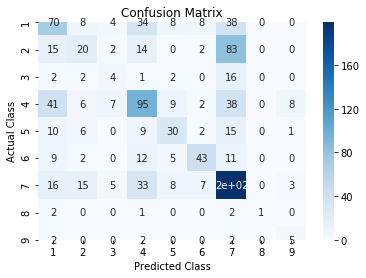

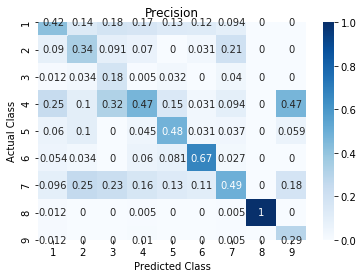

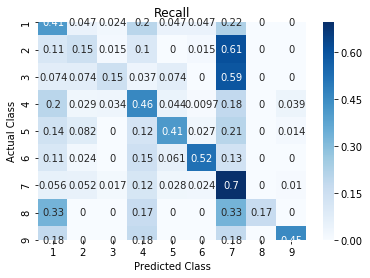

In [152]:
## Model 1: Logistic regression

logistic_regression = SGDClassifier(loss = 'log', class_weight='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
tfidfw2v_lr = model_evaluation(logistic_regression, parameters, train_data_te_tfidfw2v, y_train, test_data_te_tfidfw2v, y_test)

Results:
Logloss of train data:  1.3938717514522179
Logloss of CV data:  1.6242253641384292
Log loss of Test data: 1.688978057660064
Model accuracy: 48.7462%


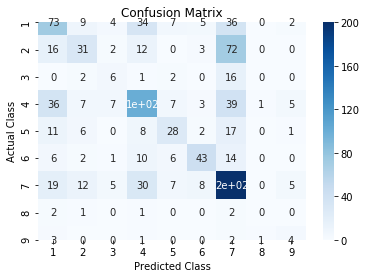

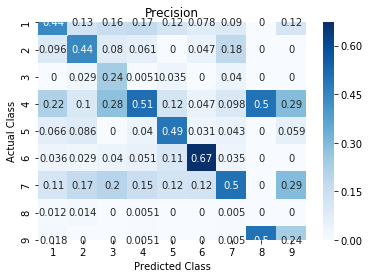

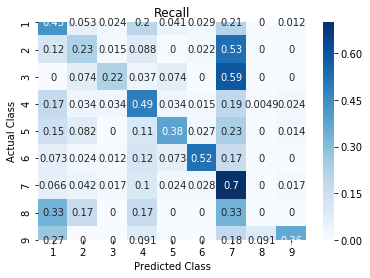

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001,
                                                                           average=False,
                                                                           class_weight='balanced',
                                                                           early_stopping=False,
                                                                           epsilon=0.1,
                                                                           eta0=0.0,
                                                                           fit_intercept=True,
                                                                           l1_ratio=0.15,
                                                                           learning_rate='optimal',
                                                                           loss='hinge',
                                         

In [98]:
## Model 2: Linear SVM

svm = SGDClassifier(loss = 'hinge', class_weight ='balanced')
parameters = {'base_estimator__alpha':[1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], 'base_estimator__l1_ratio':[0.0, 0.15, 0.25, 0.5,0.75,1]}
model_evaluation(svm, parameters, train_data_te_tfidfw2v, y_train, test_data_te_tfidfw2v, y_test)


Results:
Logloss of train data:  1.514043722267957
Logloss of CV data:  1.6714923510944133
Log loss of Test data: 1.82212691597778
Model accuracy: 42.2267%


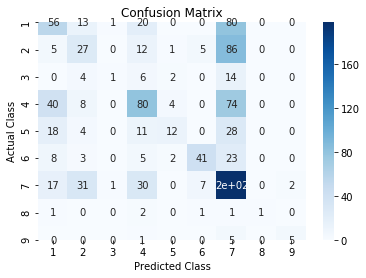

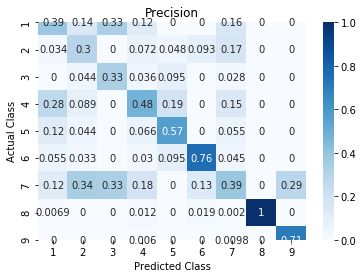

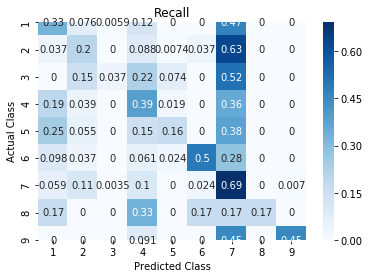

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=GaussianNB(priors=None,
                                                                        var_smoothing=1e-09),
                                              cv=None, method='isotonic'),
             iid='deprecated', n_jobs=None,
             param_grid={'base_estimator__var_smoothing': [1e-05, 0.0001, 0.001,
                                                           0.1, 1, 10, 100,
                                                           1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_log_loss', verbose=0)

In [103]:
## Model 3: Multinomial Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
parameters = {'base_estimator__var_smoothing':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
model_evaluation(gnb, parameters, train_data_te_tfidfw2v, y_train, test_data_te_tfidfw2v, y_test)


Results:
Logloss of train data:  0.45533428782113317
Logloss of CV data:  1.2438469552219302
Log loss of Test data: 3.247491274344735
Model accuracy: 62.9890%


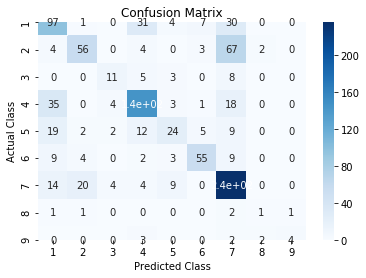

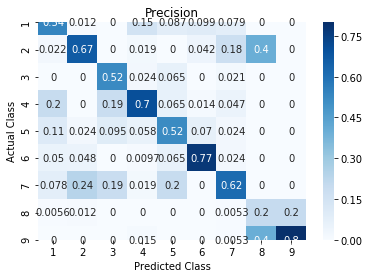

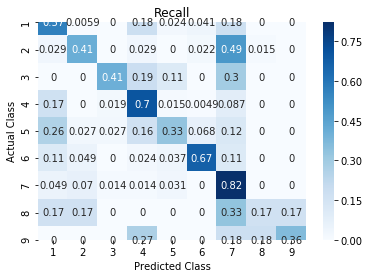

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                                                    ccp_alpha=0.0,
                                                                                    class_weight='balanced',
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    max_samples=None,
                                                                                    min_impurity_decrease=0.0,
                               

In [101]:
## Model 4: Random Forest
rf = RandomForestClassifier(class_weight='balanced')
parameters = {'base_estimator__n_estimators':[100, 200, 500, 1000], 'base_estimator__max_depth':[5,10, 15]}
model_evaluation(rf, parameters, train_data_te_tfidfw2v, y_train, test_data_te_tfidfw2v, y_test)

Results:
Logloss of train data:  0.4245829398639553
Logloss of CV data:  1.2389362558104708
Log loss of Test data: 3.4244745286207365
Model accuracy: 61.2839%


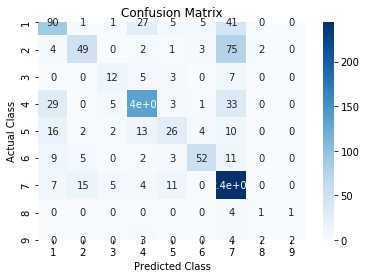

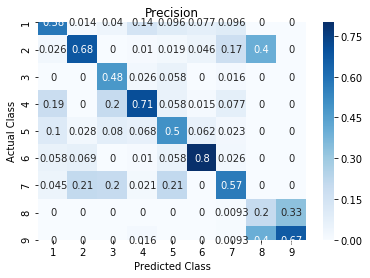

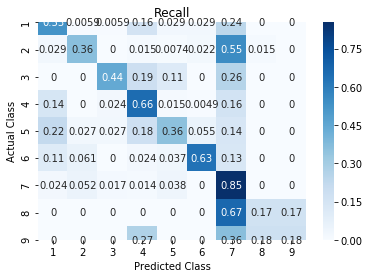

GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                                                  ccp_alpha=0.0,
                                                                                  class_weight='balanced',
                                                                                  criterion='gini',
                                                                                  max_depth=None,
                                                                                  max_features='auto',
                                                                                  max_leaf_nodes=None,
                                                                                  max_samples=None,
                                                                                  min_impurity_decrease=0.0,
                                                

In [102]:
## Model 5: Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
extrees = ExtraTreesClassifier(class_weight='balanced')
parameters = {'base_estimator__n_estimators':[100, 200, 500, 1000], 'base_estimator__max_depth':[5,10, 15]}
model_evaluation(extrees, parameters, train_data_te_tfidfw2v, y_train, test_data_te_tfidfw2v, y_test)

<a id = 'final_model'></a>
### 4. Finalized model and analysis of predicted probabilities

Logistic regression model on target encoded categorical features and tf-idf weighted word2vec 
has the lowest logloss. Let us look at their probability score to see how certain their predictions are:

In [157]:
prediction_summary = pd.DataFrame({"True_val": X_test.Class.values, "Predicted": np.argmax(tfidfw2v_lr.best_estimator_.predict_proba(test_data_te_tfidfw2v),axis=1)+1})
prediction_summary

,True_val,Predicted
0,2,7
1,1,7
2,1,5
3,7,7
4,4,7
...,...,...
992,4,2
993,1,1
994,1,7
995,6,6


The last two observations were predicted correctly. Let's check how certain the model was inpredicting the class 6

In [132]:
## Last two observations in test data set
tfidfw2v_lr.best_estimator_.predict_proba(test_data_te_tfidfw2v)[995:,:]

array([[1.70543507e-02, 1.08597450e-01, 1.12563785e-02, 4.06077461e-02,
        6.95348043e-02, 4.14985119e-01, 3.35482567e-01, 2.48158514e-03,
        0.00000000e+00],
       [6.58796923e-02, 3.73753045e-02, 3.29026782e-03, 7.59955362e-02,
        1.08198043e-01, 6.62524171e-01, 4.46605838e-02, 1.52898777e-03,
        5.47413653e-04]])

The probability of class 6 is significantly higher than the rest. 

Now, checking the predicted probability for samples where the model did not predict correctly. For the first observation, the actual output class was class2 and the predicted class was class 7. The predicted probability of class 7 is significantly higher than the rest. The model was not confused but was certain that the class was 7. This indicates that the model needs to be adjusted or retrained.

In [159]:
tfidfw2v_lr.best_estimator_.predict_proba(test_data_te_tfidfw2v)[:2,:]

array([[0.        , 0.18190822, 0.04027187, 0.17113956, 0.03934296,
        0.02703325, 0.53525523, 0.00302373, 0.00202518],
       [0.12505171, 0.16257701, 0.03767705, 0.19032531, 0.01971255,
        0.02232341, 0.43710906, 0.00290985, 0.00231405]])

Looking at the proportion of observations predicted under each class, it is clear that the model predicrs 47% of the data as class 7 and does not classify anydata into class 9 or 8. This indicates that the model needs to be modified further. 

In [158]:
print("Proportion of data under every class label")
print("Test data:")
print(prediction_summary.True_val.value_counts(normalize = True))
print("predicted data")
prediction_summary.Predicted.value_counts(normalize = True)

Proportion of data under every class label
Test data:
7    0.286861
4    0.206620
1    0.170512
2    0.136409
6    0.082247
5    0.073220
3    0.027081
9    0.011033
8    0.006018
Name: True_val, dtype: float64
predicted data


7    0.468405
4    0.201605
1    0.156469
5    0.063190
6    0.059178
2    0.040120
3    0.011033
Name: Predicted, dtype: float64

- Logistic regression on tfidf-w2v predicts class 6 with high precision of 64%. The recall for class 7 is high 68% as the model predicts majority (45%) of the classses as class 7. 
- Class 8 and 9 has the lowest number of observations and the model did not classify any observation into class 8 or 9
- This indicates that the model's prediction is affected by the number of observations

<a id = 'next_steps'> </a>
### 5. Next Steps

#### What else can be done to improve the model/find the best model

- Change train/test split dataset with 80:20 (instead of 70:30). There is quite some variation in the text data between train and test data set. And we can try to see if this can help
- Feature engineering on text data: 
    - Text preprocessing: 
        - Remove named organizations, cities and other geographical names. (Spacy confuses some chemical/molecular name with geogeaphical entity)
        - Identify abbreviations and remove duplicated features
        - Further engineering of text features is required. Without domain knowledge, this is very challenging
- Feature engineering of gene abd variation categorical variables: Combine gene and variation into one feature by appending the contents of gene and variation: <-- This might lead to overfitting

